In [2]:
%load_ext autoreload
%autoreload 2

import pandas as pd
from analysis import *
from getters import * 
from plotters import *

In [138]:
pd.DataFrame(mean_all_runs, columns=["View {}".format(i) for i in views]+ ["Average"], index=["Teacher", "Student", "Student + Teacher", "Student + Teacher + Weight Loss"])

,View 0,View 2,View 4,View 5,Average
Teacher,0.535972,0.508611,0.536944,0.503194,0.521181
Student,0.481667,0.544167,0.482083,0.538472,0.511597
Student + Teacher,0.484583,0.558889,0.497639,0.531528,0.518160
Student + Teacher + Weight Loss,0.493056,0.529444,0.486528,0.477778,0.496701


# Analysis for each view we create the metric tables across the different models 

In [3]:
def metric_and_view_analysis(models, CV, analysis_type, view, run, dataset_split, dataset, metric):
    """
    Mean of metric for a specific CV -> 3, 5 or 10
    """

    all_data_mean = []
    all_data_std = []
    
    for model in models:
        
        model_results_mean = []
        model_results_std = []
       
        for training_type in CV:
            metrics = extract_metrics(dataset=dataset, model=model, analysis_type=analysis_type, training_type=training_type, view=view, run=run, dataset_split=dataset_split, metric=metric)
            mean = np.mean([metric[-1] for metric in metrics])
            std = np.std([metric[-1] for metric in metrics])
            model_results_mean.append(mean)
            model_results_std.append(std)
        
        all_data_mean.append(model_results_mean)
        all_data_std.append(model_results_std)
    
    return all_data_mean, all_data_std

In [4]:
def view_metric_analysis(models, CV, view, run, metric, dataset):

    view_data_mean = []
    view_data_std = []

    mean, std = metric_and_view_analysis(models=models, 
                                    CV=CV, 
                                    analysis_type="model_assessment", 
                                    view=view, 
                                    run=run, 
                                    dataset= dataset,
                                    dataset_split="val", 
                                    metric=metric)
    view_data_mean.append(mean)
    view_data_std.append(std)
    
    return view_data_mean, view_data_std 

In [207]:
mean_all_runs = []
for run in [i for i in range(10)]:
    view_data_mean, view_data_std = view_metric_analysis(models=models, CV=CV, view=0, run=run, metric="acc", dataset=dataset)
    mean_all_runs.append(view_data_mean)

mean_all_std = np.std(mean_all_runs, axis=0).squeeze()
mean_all_runs = np.mean(mean_all_runs, axis=0).squeeze()

#GET MEAN AND STD ACROSS MEAN OF RUNS
mean_all_runs = np.c_[ mean_all_runs, np.mean(mean_all_runs, axis=1)]     
mean_all_std = np.c_[ mean_all_std, np.std(mean_all_runs, axis=1)]  

mean_all_runs, mean_all_std

(array([[0.60686954, 0.60995643, 0.60961415, 0.60881337],
        [0.57161681, 0.59281791, 0.59920572, 0.58788015],
        [0.57749533, 0.59901104, 0.60518728, 0.59389788],
        [0.54751081, 0.55423042, 0.5613834 , 0.55437487]]),
 array([[0.01529327, 0.01794911, 0.01028801, 0.00119649],
        [0.0249576 , 0.0170908 , 0.01732294, 0.01021208],
        [0.02112357, 0.01607898, 0.0171574 , 0.01027909],
        [0.01541351, 0.01567641, 0.01292345, 0.0049055 ]]))

In [5]:
views=[0, 2, 4, 5]
models=["gcn", "gcn_student", "gcn_student_teacher", "gcn_student_teacher_weight"]
CV=["3Fold", "5Fold", "10Fold"]
run=1
dataset = "gender_data"
dataset_split = ["val", "train", "test"]
metrics = ["acc", "f1", "recall", "precision"]

for view in views:
    for metric in metrics:
        print("____________________________________________________")
        print(f"View: {view} Metric: {metric}")
        mean, std = metric_and_view_analysis(models=models, 
                                            CV=CV, 
                                            analysis_type="model_assessment", 
                                            view=view, 
                                            run=run, 
                                            dataset= dataset,
                                            dataset_split="val", 
                                            metric=metric)
        mean = pd.DataFrame(mean, columns=CV, index=["Teacher", "Student", "Student + Teacher", "Student + Teacher + Weight Loss"]).round(3)
        std = pd.DataFrame(std, columns=CV, index=["Teacher", "Student", "Student + Teacher", "Student + Teacher + Weight Loss"]).round(3)
        print(mean.astype(str) + u"\u00B1" + std.astype(str))

____________________________________________________
View: 0 Metric: acc
                                       3Fold        5Fold       10Fold
Teacher                          0.602±0.017  0.593±0.038  0.599±0.057
Student                          0.571±0.049  0.603±0.042  0.575±0.042
Student + Teacher                0.582±0.042  0.602±0.042  0.592±0.042
Student + Teacher + Weight Loss   0.532±0.01    0.54±0.04   0.56±0.058
____________________________________________________
View: 0 Metric: f1
                                       3Fold        5Fold       10Fold
Teacher                          0.437±0.046   0.487±0.04  0.519±0.068
Student                          0.381±0.087   0.467±0.08  0.423±0.095
Student + Teacher                  0.35±0.14  0.492±0.071   0.436±0.13
Student + Teacher + Weight Loss   0.17±0.094  0.339±0.077  0.311±0.167
____________________________________________________
View: 0 Metric: recall
                                       3Fold        5Fold       10Fol

In [213]:
import io

class CPU_Unpickler(pickle.Unpickler):
    def find_class(self, module, name):
        if module == 'torch.storage' and name == '_load_from_bytes':
            return lambda b: torch.load(io.BytesIO(b), map_location='cpu')
        else: return super().find_class(module, name)

cv_path_1 = SAVE_DIR_MODEL_DATA+'model_assessment/gcn/weights/W_MainModel_3Fold_gender_data_gcn_run_0_CV_0_view_0_TEST.pickle'
cv_path_2 = SAVE_DIR_MODEL_DATA+'model_assessment/gcn/weights/W_MainModel_3Fold_gender_data_gcn_run_0_CV_0_view_0_TEST_2.pickle'
cv_path_3 = SAVE_DIR_MODEL_DATA+'model_assessment/gcn/weights/W_MainModel_3Fold_gender_data_gcn_run_0_CV_0_view_0_TEST_3.pickle'

with open(cv_path_1,'rb') as f:
    weights_1 = CPU_Unpickler(f).load()

with open(cv_path_2,'rb') as f:
    weights_2 = CPU_Unpickler(f).load()

with open(cv_path_3,'rb') as f:
    weights_2 = CPU_Unpickler(f).load()

print(weights_1)
print(weights_2)

Ks = [5, 10, 15, 20]
teacher_weights = weights_1["w"].squeeze().detach().numpy()
student_weight = weights_2["w"].squeeze().detach().numpy()
for k in Ks:
    top_bio_i = top_biomarkers(teacher_weights, k)
    top_bio_j = top_biomarkers(student_weight, k)
    print(top_bio_i)
    print(top_bio_j)
    print(sim(top_bio_i, top_bio_j))


{'w': Parameter containing:
tensor([[-0.1489,  0.0162, -0.1194, -0.0202, -0.1403, -0.1091, -0.0803,  0.1808,
         -0.0033,  0.0470,  0.0215,  0.0081, -0.0315, -0.1461, -0.0013,  0.1489,
         -0.0930,  0.1272, -0.0292,  0.0739, -0.0244, -0.0515, -0.1271, -0.0550,
          0.0735,  0.0621,  0.0910,  0.1108,  0.0337,  0.1760, -0.0632,  0.0315,
          0.0906,  0.1465, -0.0711]], requires_grad=True)}
{'w': Parameter containing:
tensor([[-0.0586, -0.0967, -0.0213, -0.0423,  0.0074,  0.1082,  0.1008, -0.0700,
          0.1325,  0.1787,  0.0710, -0.1253,  0.1156, -0.0651,  0.0839, -0.0171,
          0.1840,  0.0957, -0.0952, -0.1685,  0.0776, -0.1542,  0.2262,  0.2231,
          0.0125,  0.1908, -0.1573,  0.1821,  0.1211, -0.1819, -0.0794, -0.0089,
          0.0631, -0.0487,  0.0266]], requires_grad=True)}
[7, 29, 15, 0, 33]
[22, 23, 25, 16, 27]
0.0
[7, 29, 15, 0, 33, 13, 4, 17, 22, 2]
[22, 23, 25, 16, 27, 29, 9, 19, 26, 21]
0.2
[7, 29, 15, 0, 33, 13, 4, 17, 22, 2, 27, 5, 16, 26, 3

In [12]:
import torch

# Create a 3x3x4 tensor
tensor = torch.tensor([
    [[1, 2, 3, 4], [5, 6, 7, 8], [9, 10, 11, 12]],
    [[13, 14, 15, 16], [17, 18, 19, 20], [21, 22, 23, 24]],
    [[25, 26, 27, 28], [29, 30, 31, 32], [33, 34, 35, 36]]
])

# Define the coefficients for multiplication and addition
coefficients = torch.tensor([0.5, 2.0, 1.5, 0.1])

# Multiply and accumulate along the third axis
result = tensor[:, :, 0]
for i in range(1, tensor.shape[2]):
    result = result * coefficients[i-1] + tensor[:, :, i]

# Print the result
print(result)


tensor([[ 16.,  44.,  72.],
        [100., 128., 156.],
        [184., 212., 240.]])


In [18]:
tensor.shape

torch.Size([3, 3, 4])

In [21]:
np.zeros([3,3,4])

array([[[0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.]],

       [[0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.]],

       [[0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.]]])

In [24]:

import torch

# Create 4 individual 3x3 matrices
matrix1 = torch.tensor([[1, 2, 3], [4, 5, 6], [7, 8, 9]])
matrix2 = torch.tensor([[10, 11, 12], [13, 14, 15], [16, 17, 18]])
matrix3 = torch.tensor([[19, 20, 21], [22, 23, 24], [25, 26, 27]])
matrix4 = torch.tensor([[28, 29, 30], [31, 32, 33], [34, 35, 36]])

# Stack the matrices along the first dimension to create a (3x3) x 4 tensor
tensor = torch.stack([matrix1, matrix2, matrix3, matrix4], dim=0)

# Print the tensor
print(tensor.shape)

torch.Size([4, 3, 3])


In [73]:
def sim(nodes1, nodes2):
    if len(nodes1)==len(nodes2):
        counter = 0
        for i in nodes1:
            for k in nodes2:
                if i==k:
                    counter+=1
        return counter/len(nodes1)

    else:
        print('nodes vectors are not compatible')
        
def view_specific_rep(dataset, view, model, CV, run):

    Ks = [5, 10, 15, 20]
    rep = np.zeros([len(Ks), len(CV), len(CV)])

    for k in range(rep.shape[0]):
        for i in range(rep.shape[1]):
            for j in range(rep.shape[2]):
                weights_i = extract_weights(dataset, view, model, CV[i], run)
                weights_j = extract_weights(dataset, view, model, CV[j], run)
                top_bio_i = top_biomarkers(weights_i, Ks[k])
                top_bio_j = top_biomarkers(weights_j, Ks[k])
                rep[k,i,j] = sim(top_bio_i, top_bio_j)
    
    print(rep)
    # Define the coefficients for multiplication and addition
    coefficients = np.array([0.25, 0.25, 0.25, 0.25])

    # Multiply and accumulate along the third axis
    rep_mean = np.zeros([3,3])
    print(rep_mean)
    for i in range(0, rep.shape[0]):
        rep_mean = rep_mean * coefficients[i] + rep[i, :, :]
    
    print(rep_mean)
    # Get the elements above the diagonal
    elements_above_diagonal = np.where(np.triu(np.ones_like(rep_mean), k=1), rep_mean, np.nan)

    # Drop the zeros and calculate the average
    average = np.nanmean(elements_above_diagonal)
    std = np.nanstd(elements_above_diagonal)
    
    return average, std

In [74]:
view_specific_rep(dataset="gender_data", view=0, model="gcn", CV= ["3Fold", "5Fold", "10Fold"], run=1)

[[[1.         0.2        0.        ]
  [0.2        1.         0.2       ]
  [0.         0.2        1.        ]]

 [[1.         0.8        0.2       ]
  [0.8        1.         0.2       ]
  [0.2        0.2        1.        ]]

 [[1.         0.73333333 0.4       ]
  [0.73333333 1.         0.33333333]
  [0.4        0.33333333 1.        ]]

 [[1.         0.75       0.7       ]
  [0.75       1.         0.6       ]
  [0.7        0.6        1.        ]]]
[[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]
[[1.328125   0.98645833 0.8125    ]
 [0.98645833 1.328125   0.69895833]
 [0.8125     0.69895833 1.328125  ]]


(0.8326388888888889, 0.11823209838916914)

In [53]:
def view_specific_rep(dataset, view, model, CV, run):

    Ks = [5, 10, 15, 20]
    rep = np.zeros([len(CV), len(CV), len(Ks)])

    for i in range(rep.shape[0]):
        for j in range(rep.shape[1]):
            weights_i = extract_weights(dataset, view, model, CV[i], run)
            weights_j = extract_weights(dataset, view, model, CV[j], run)
            
            for k in range(rep.shape[2]):
                top_bio_i = top_biomarkers(weights_i, Ks[k])
                top_bio_j = top_biomarkers(weights_j, Ks[k])
                rep[i,j,k] = sim(top_bio_i, top_bio_j)
                
    rep_mean = np.mean(rep, axis=2)
    # Get the elements above the diagonal
    elements_above_diagonal = np.where(np.triu(np.ones_like(rep_mean), k=1), rep_mean, np.nan)

    # Drop the zeros and calculate the average
    average = np.nanmean(elements_above_diagonal)
    std = np.nanstd(elements_above_diagonal)
    
    return average, std


In [54]:
view_specific_rep(dataset="gender_data", view=0, model="gcn", CV= ["3Fold", "5Fold", "10Fold"], run=1)

(0.42638888888888893, 0.1375350684797459)

In [76]:
from loaders import *

G_list = load_data("gender_data", 0, NormalizeInputGraphs=False)


In [77]:
len(G_list)

698

In [71]:
%load_ext autoreload
%autoreload 2

import pandas as pd
from analysis import *
from getters import * 
from plotters import * 

views=[0]
models=["gcn_student_ensamble_3"]
CV=["3Fold", "5Fold", "10Fold"]
run=0
dataset = "gender_data"
gcn_student_ensamble_args = {
    "num_epochs":50, 
    "lr": 0.0001, # 0.0001 when training without teacher
    "weight_decay":5e-4, 
    "hidden_dim":64,
    "dropout":0,
    "threshold":"median", # Threshold the graph adjacency matrix. Possible values: no_threshold, median, mean
    "model_name":"gcn_student_ensamble_3",
    "evaluation_method": "model_assessment", # model selection or model assessment
    "alpha": 1, # ensamble ce loss
    "beta": 2,  # ensamble kd loss
    "gamma": 2, # sum of student ce loss
    "lambda":1, # disentanglement loss
    "T": 3, #Temperature parameter for soft logit target 
    "n_students":3 # TOTAL number of students in ensamble 
}

view_data_mean, _ = view_reproducibility_analysis(dataset, models, CV, views, run, student=0, model_args=gcn_student_ensamble_args)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [73]:
view_data_mean_1, _ = view_reproducibility_analysis(dataset, models, CV, views, run, student=0, model_args=gcn_student_ensamble_args)
view_data_mean_2, _ = view_reproducibility_analysis(dataset, models, CV, views, run, student=1, model_args=gcn_student_ensamble_args)
view_data_mean_3, _ = view_reproducibility_analysis(dataset, models, CV, views, run, student=2, model_args=gcn_student_ensamble_args)

In [74]:
view_data_mean_1, view_data_mean_2, view_data_mean_3

(array([[0.88888889, 0.88888889]]),
 array([[0.93333333, 0.93333333]]),
 array([[0.98333333, 0.98333333]]))

In [52]:
gcn_student_ensamble_args = {
    "num_epochs":50, 
    "lr": 0.0001, # 0.0001 when training without teacher
    "weight_decay":5e-4, 
    "hidden_dim":64,
    "dropout":0,
    "threshold":"median", # Threshold the graph adjacency matrix. Possible values: no_threshold, median, mean
    "model_name":"gcn_student_ensamble_3",
    "evaluation_method": "model_assessment", # model selection or model assessment
    "alpha": 1, # ensamble ce loss
    "beta": 2,  # ensamble kd loss
    "gamma": 2, # sum of student ce loss
    "lambda":1, # disentanglement loss
    "T": 3, #Temperature parameter for soft logit target 
    "n_students":3 # TOTAL number of students in ensamble 
}

x = get_labels_and_preds(dataset, "gcn_student_ensamble_3","model_assessment", "5Fold",  4, 0, 0, "val", student=1, model_args=gcn_student_ensamble_args)

In [87]:
student = []
acc_mean = []
for i in range(3):
    for i in range(3):
        x = get_labels_and_preds(dataset, "gcn_student_ensamble_3","model_assessment", "3Fold",  i, 0, 0, "val", student=2, model_args=gcn_student_ensamble_args)
        result = {
        'prec': metrics.precision_score(x['labels'],  x['preds']),
        'recall': metrics.recall_score(x['labels'],  x['preds']),
        'acc': metrics.accuracy_score(x['labels'],  x['preds']),
        'F1': metrics.f1_score(x['labels'],  x['preds'])
        }   
        acc_mean.append(result['acc'])
    student.append(np.mean(acc_mean))
np.mean(student)

0.5501768346595933

In [88]:
student = []
acc_mean = []
for i in range(5):
    for i in range(5):
        x = get_labels_and_preds(dataset, "gcn_student_ensamble_3","model_assessment", "5Fold",  i, 0, 0, "val", student=2, model_args=gcn_student_ensamble_args)
        result = {
        'prec': metrics.precision_score(x['labels'],  x['preds']),
        'recall': metrics.recall_score(x['labels'],  x['preds']),
        'acc': metrics.accuracy_score(x['labels'],  x['preds']),
        'F1': metrics.f1_score(x['labels'],  x['preds'])
        }   
        acc_mean.append(result['acc'])
    student.append(np.mean(acc_mean))
np.mean(student)

0.5183098591549296

In [89]:
student = []
acc_mean = []
for i in range(10):
    for i in range(10):
        x = get_labels_and_preds(dataset, "gcn_student_ensamble_3","model_assessment", "10Fold",  i, 0, 0, "val", student=2, model_args=gcn_student_ensamble_args)
        result = {
        'prec': metrics.precision_score(x['labels'],  x['preds']),
        'recall': metrics.recall_score(x['labels'],  x['preds']),
        'acc': metrics.accuracy_score(x['labels'],  x['preds']),
        'F1': metrics.f1_score(x['labels'],  x['preds'])
        }   
        acc_mean.append(result['acc'])
    student.append(np.mean(acc_mean))
np.mean(student)

0.541501976284585

## GET THE STUFF

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class MLP(nn.Module):
    def __init__(
        self,
        num_layers,
        input_dim,
        hidden_dim,
        output_dim,
        dropout_ratio,
        norm_type="none",
    ):
        super(MLP, self).__init__()
        self.num_layers = num_layers
        self.norm_type = norm_type
        self.dropout = nn.Dropout(dropout_ratio)
        self.layers = nn.ModuleList()
        self.norms = nn.ModuleList()

        if num_layers == 1:
            self.layers.append(nn.Linear(input_dim, output_dim))
        else:
            self.layers.append(nn.Linear(input_dim, hidden_dim))
            if self.norm_type == "batch":
                self.norms.append(nn.BatchNorm1d(hidden_dim))
            elif self.norm_type == "layer":
                self.norms.append(nn.LayerNorm(hidden_dim))

            for i in range(num_layers - 2):
                self.layers.append(nn.Linear(hidden_dim, hidden_dim))
                if self.norm_type == "batch":
                    self.norms.append(nn.BatchNorm1d(hidden_dim))
                elif self.norm_type == "layer":
                    self.norms.append(nn.LayerNorm(hidden_dim))

            self.layers.append(nn.Linear(hidden_dim, output_dim))

    def forward(self, feats):
        h = feats
        h_list = []
        for l, layer in enumerate(self.layers):
            h = layer(h)
            if l != self.num_layers - 1:
                h_list.append(h)
                if self.norm_type != "none":
                    h = self.norms[l](h)
                h = F.relu(h)
                h = self.dropout(h)
        h = torch.reshape(h, (1, 2)) 
        h = F.log_softmax(h, dim=1)
        return h_list, h
    
    def loss(self, pred, label, type='softmax'):
        return F.cross_entropy(pred, label, reduction='mean')

In [10]:
mlp_args = {
    "num_epochs":50, 
    "lr": 0.001,
    "weight_decay":5e-4, 
    "num_layers":1, 
    "input_dim":595,
    "hidden_dim":35,
    "output_dim":2, 
    "threshold":"median", # Threshold the graph adjacency matrix. Possible values: no_threshold, median, mean
    "dropout_ratio":0,
    "model_name":"mlp",
    "evaluation_method": "model_assessment" # model selection or model assessment
}

In [15]:
model = MLP(
    num_layers=mlp_args["num_layers"], 
    input_dim=35, 
    hidden_dim=mlp_args["hidden_dim"], 
    output_dim=1, 
    dropout_ratio=mlp_args["dropout_ratio"]
)

In [19]:
model


Parameter containing:
tensor([[ 0.1491,  0.0852,  0.0390,  0.0971, -0.1071, -0.1038,  0.1652, -0.0666,
         -0.0883,  0.1474, -0.1329, -0.1011, -0.0036,  0.1021, -0.1615, -0.0489,
         -0.0589,  0.0684, -0.0209, -0.1641, -0.0371,  0.1045,  0.0242,  0.0600,
         -0.1608, -0.0004, -0.1493,  0.0713, -0.0711, -0.1553,  0.0791,  0.1515,
         -0.1011, -0.0553,  0.0281]], requires_grad=True)

In [17]:
pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
pytorch_total_params

36

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class MLP(nn.Module):
    def __init__(
        self,
        num_layers,
        input_dim,
        hidden_dim,
        output_dim,
        dropout_ratio,
        norm_type="none",
    ):
        super(MLP, self).__init__()
        self.num_layers = num_layers
        self.norm_type = norm_type
        self.dropout = nn.Dropout(dropout_ratio)
        self.layers = nn.ModuleList()
        self.norms = nn.ModuleList()

        if num_layers == 1:
            self.layers.append(nn.Linear(input_dim, output_dim))
        else:
            self.layers.append(nn.Linear(input_dim, hidden_dim))
            if self.norm_type == "batch":
                self.norms.append(nn.BatchNorm1d(hidden_dim))
            elif self.norm_type == "layer":
                self.norms.append(nn.LayerNorm(hidden_dim))

            for i in range(num_layers - 2):
                self.layers.append(nn.Linear(hidden_dim, hidden_dim))
                if self.norm_type == "batch":
                    self.norms.append(nn.BatchNorm1d(hidden_dim))
                elif self.norm_type == "layer":
                    self.norms.append(nn.LayerNorm(hidden_dim))

            self.layers.append(nn.Linear(hidden_dim, output_dim))

    def forward(self, feats):
        h = feats
        h_list = []
        for l, layer in enumerate(self.layers):
            h = layer(h)
            if l != self.num_layers - 1:
                h_list.append(h)
                if self.norm_type != "none":
                    h = self.norms[l](h)
                h = F.relu(h)
                h = self.dropout(h)
        h = torch.reshape(h, (1, 2)) 
        h = F.log_softmax(h, dim=1)
        return h_list, h
    
    def loss(self, pred, label, type='softmax'):
        return F.cross_entropy(pred, label, reduction='mean')

In [ ]:
"""
tensor([[-0.1089, -0.0054]], grad_fn=<TransposeBackward0>)
tensor([1])
tensor([[-3.3377,  0.0469]], grad_fn=<TransposeBackward0>)
_____
_____
torch.Size([1, 2])
torch.Size([1])
torch.Size([1, 2])z
________
tensor(0.6931, grad_fn=<NllLossBackward>)
tensor([[-0.4164, -0.4164]], grad_fn=<ViewBackward>) tensor([1])
tensor(0.6931, grad_fn=<NegBackward>)
tensor([[-0.4164, -0.4164]], grad_fn=<ViewBackward>) tensor([[-1.0135,  0.0066]], grad_fn=<TransposeBackward0>)
________

________
tensor(0.5893, grad_fn=<NllLossBackward>)
tensor([[-0.2147,  0.0050]], grad_fn=<TransposeBackward0>) tensor([1])
tensor(0.7019, grad_fn=<NegBackward>)
tensor([[-0.2147,  0.0050]], grad_fn=<TransposeBackward0>) tensor([[ 0.6398, -0.7032]], grad_fn=<TransposeBackward0>)
________
"""

In [61]:
gcn_student_args = {
    "num_epochs":50, 
    "lr": 0.0001, 
    "weight_decay":5e-4, 
    "hidden_dim":64,
    "dropout":0,
    "threshold":"median", # Threshold the graph adjacency matrix. Possible values: no_threshold, median, mean
    "model_name":"gcn_student",
    "evaluation_method": "model_assessment", # model selection or model assessment
    "alpha_ce": 1, 
    "T": 3, 
    "alpha_soft_ce": 2,
    "alpha_kd_lsp":2,
    "alpha_weight": 0
}

lsp_student_args = {
    "num_epochs":50, 
    "lr": 0.001, 
    "weight_decay":5e-4, 
    "hidden_dim":64,
    "dropout":0,
    "threshold":"median", # Threshold the graph adjacency matrix. Possible values: no_threshold, median, mean
    "model_name":"lsp",
    "evaluation_method": "model_assessment", # model selection or model assessment
    "alpha_ce": 1, 
    "T": 3, 
    "alpha_soft_ce": 2,
    "alpha_kd_lsp":2,
    "alpha_weight": 0
}
mskd_student_args = {
    "num_epochs":50, 
    "lr": 0.001, 
    "weight_decay":5e-4, 
    "hidden_dim":64,
    "dropout":0,
    "threshold":"median", # Threshold the graph adjacency matrix. Possible values: no_threshold, median, mean
    "model_name":"mskd",
    "evaluation_method": "model_assessment", # model selection or model assessment
    "alpha_ce": 1, 
    "T": 3, 
    "alpha_soft_ce": 4,
    "alpha_mskd": 2
}


gcn_args = {
    "num_epochs":50, 
    "lr": 0.0001,
    "weight_decay":5e-4, 
    "hidden_dim":64,
    "dropout":0,
    "threshold":"median", # Threshold the graph adjacency matrix. Possible values: no_threshold, median, mean
    "model_name":"gcn",
    "layers":2,
    "evaluation_method": "model_assessment" # model selection or model assessment
}

fitnet_student_args = {
    "num_epochs":50, 
    "lr": 0.001, 
    "weight_decay":1e-3, 
    "hidden_dim":64,
    "dropout":0,
    "threshold":"median", # Threshold the graph adjacency matrix. Possible values: no_threshold, median, mean
    "model_name":"fitnet",
    "evaluation_method": "model_assessment", # model selection or model assessment
    "alpha_ce": 1, 
    "T": 2, 
    "alpha_soft_ce": 2,
    "alpha_kd_lsp": 1
}


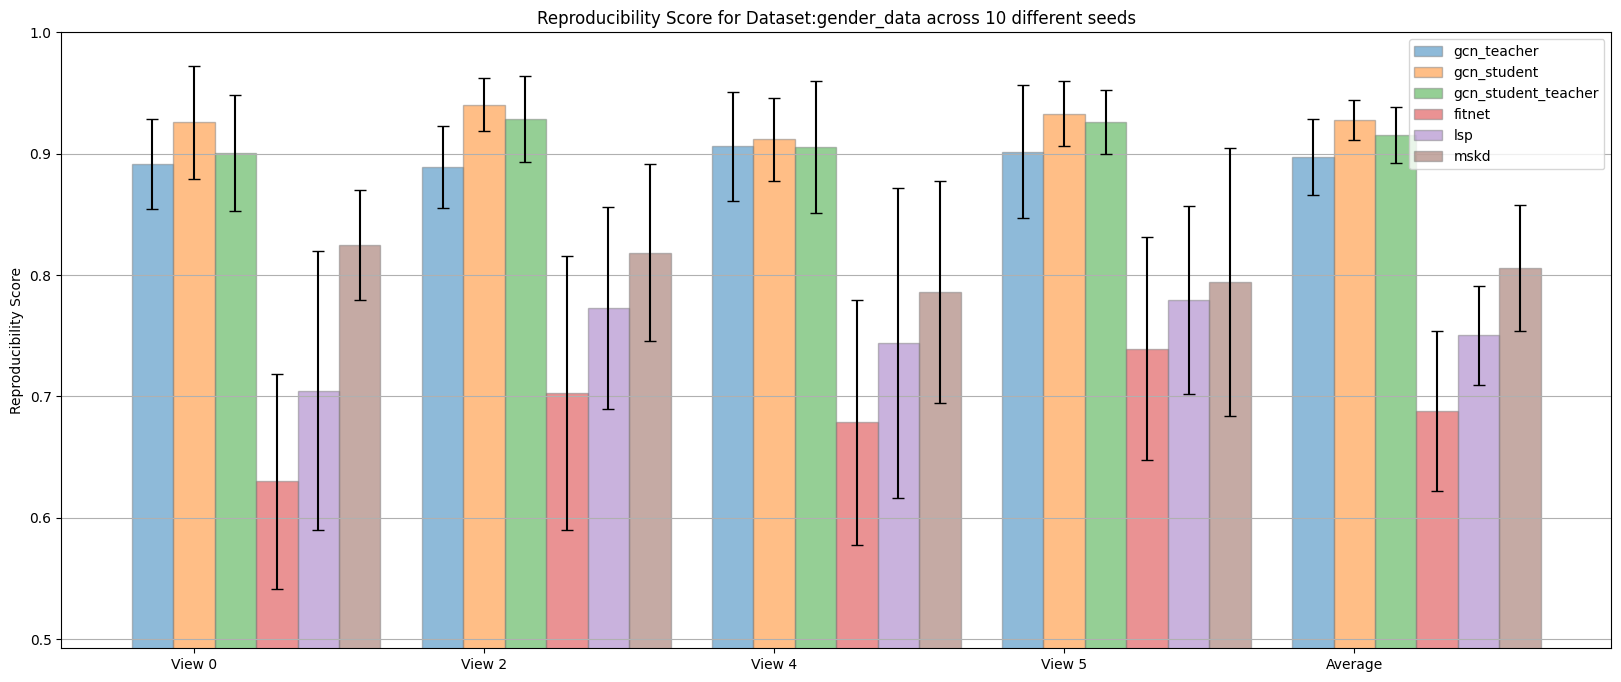

<Figure size 2000x800 with 0 Axes>

In [83]:
dataset="gender_data"
views=[0, 2, 4, 5]
models=["gcn", "gcn_student", "gcn_student_teacher","fitnet", "lsp", "mskd"]
model_args = [gcn_args, gcn_student_args, gcn_student_args, fitnet_student_args, lsp_student_args, mskd_student_args]
CV=["3Fold", "5Fold", "10Fold"]
runs=[i for i in range(10)]
save_fig=False

plot_bar_chart_reproducibility_mulitple_runs(dataset, views, models, CV, runs, students=[-1,-1,-1,-1,-1,-1], model_args=model_args, save_fig=False)

In [81]:
for view in [0, 2, 4, 5]:
    plot_bar_chart_metric_multiple_runs(dataset="gender_data", view=view, models=["gcn", "gcn_student", "gcn_student_teacher","fitnet", "lsp", "mskd"], CV=["3Fold", "5Fold", "10Fold"], runs=[i for i in range(10)], metric="acc", dataset_split="val", analysis_type="model_assessment", save_fig=True)
    plot_bar_chart_metric_multiple_runs(dataset="gender_data", view=view, models=["gcn", "gcn_student", "gcn_student_teacher","fitnet", "lsp", "mskd"], CV=["3Fold", "5Fold", "10Fold"], runs=[i for i in range(10)], metric="f1", dataset_split="val", analysis_type="model_assessment", save_fig=True)
    plot_bar_chart_metric_multiple_runs(dataset="gender_data", view=view, models=["gcn", "gcn_student", "gcn_student_teacher","fitnet", "lsp", "mskd"], CV=["3Fold", "5Fold", "10Fold"], runs=[i for i in range(10)], metric="precision", dataset_split="val", analysis_type="model_assessment", save_fig=True)
    plot_bar_chart_metric_multiple_runs(dataset="gender_data", view=view, models=["gcn", "gcn_student", "gcn_student_teacher","fitnet", "lsp", "mskd"], CV=["3Fold", "5Fold", "10Fold"], runs=[i for i in range(10)], metric="recall", dataset_split="val", analysis_type="model_assessment", save_fig=True)


<Figure size 1500x500 with 0 Axes>

/Users/lorenzostigliano/Documents/University/Imperial/Summer Term/thesis-imperial/model_data/model_assessment/gcn_student/training_loss/training_loss_MainModel_5Fold_gender_data_gcn_student_run_0_CV_0_view_0.pickle
/Users/lorenzostigliano/Documents/University/Imperial/Summer Term/thesis-imperial/model_data/model_assessment/gcn_student/validation_loss/validation_loss_MainModel_5Fold_gender_data_gcn_student_run_0_CV_0_view_0.pickle
/Users/lorenzostigliano/Documents/University/Imperial/Summer Term/thesis-imperial/model_data/model_assessment/gcn_student/training_loss/training_loss_MainModel_5Fold_gender_data_gcn_student_run_0_CV_1_view_0.pickle
/Users/lorenzostigliano/Documents/University/Imperial/Summer Term/thesis-imperial/model_data/model_assessment/gcn_student/validation_loss/validation_loss_MainModel_5Fold_gender_data_gcn_student_run_0_CV_1_view_0.pickle
/Users/lorenzostigliano/Documents/University/Imperial/Summer Term/thesis-imperial/model_data/model_assessment/gcn_student/training_l

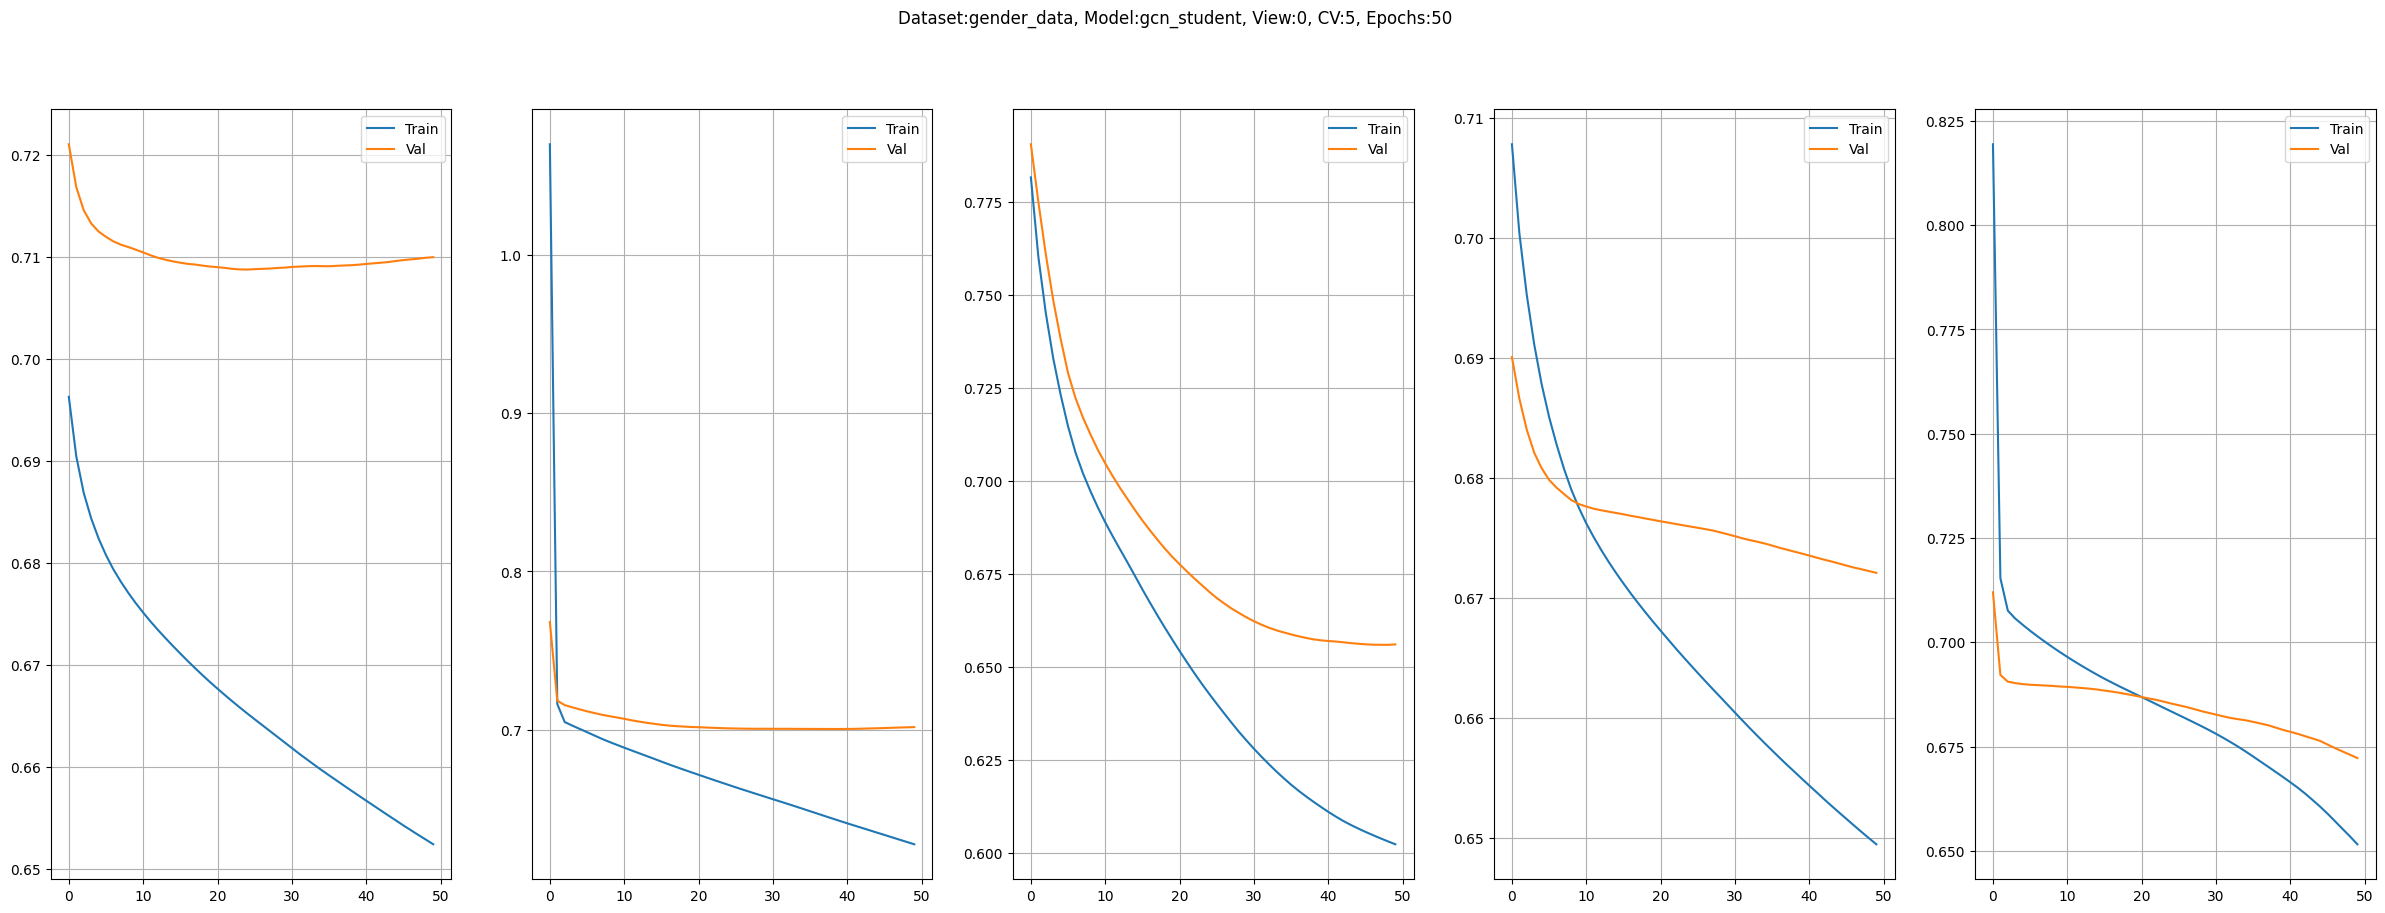

/Users/lorenzostigliano/Documents/University/Imperial/Summer Term/thesis-imperial/model_data/model_assessment/gcn_student/training_loss/training_loss_MainModel_5Fold_gender_data_gcn_student_run_0_CV_0_view_2.pickle
/Users/lorenzostigliano/Documents/University/Imperial/Summer Term/thesis-imperial/model_data/model_assessment/gcn_student/validation_loss/validation_loss_MainModel_5Fold_gender_data_gcn_student_run_0_CV_0_view_2.pickle
/Users/lorenzostigliano/Documents/University/Imperial/Summer Term/thesis-imperial/model_data/model_assessment/gcn_student/training_loss/training_loss_MainModel_5Fold_gender_data_gcn_student_run_0_CV_1_view_2.pickle
/Users/lorenzostigliano/Documents/University/Imperial/Summer Term/thesis-imperial/model_data/model_assessment/gcn_student/validation_loss/validation_loss_MainModel_5Fold_gender_data_gcn_student_run_0_CV_1_view_2.pickle
/Users/lorenzostigliano/Documents/University/Imperial/Summer Term/thesis-imperial/model_data/model_assessment/gcn_student/training_l

<Figure size 1500x500 with 0 Axes>

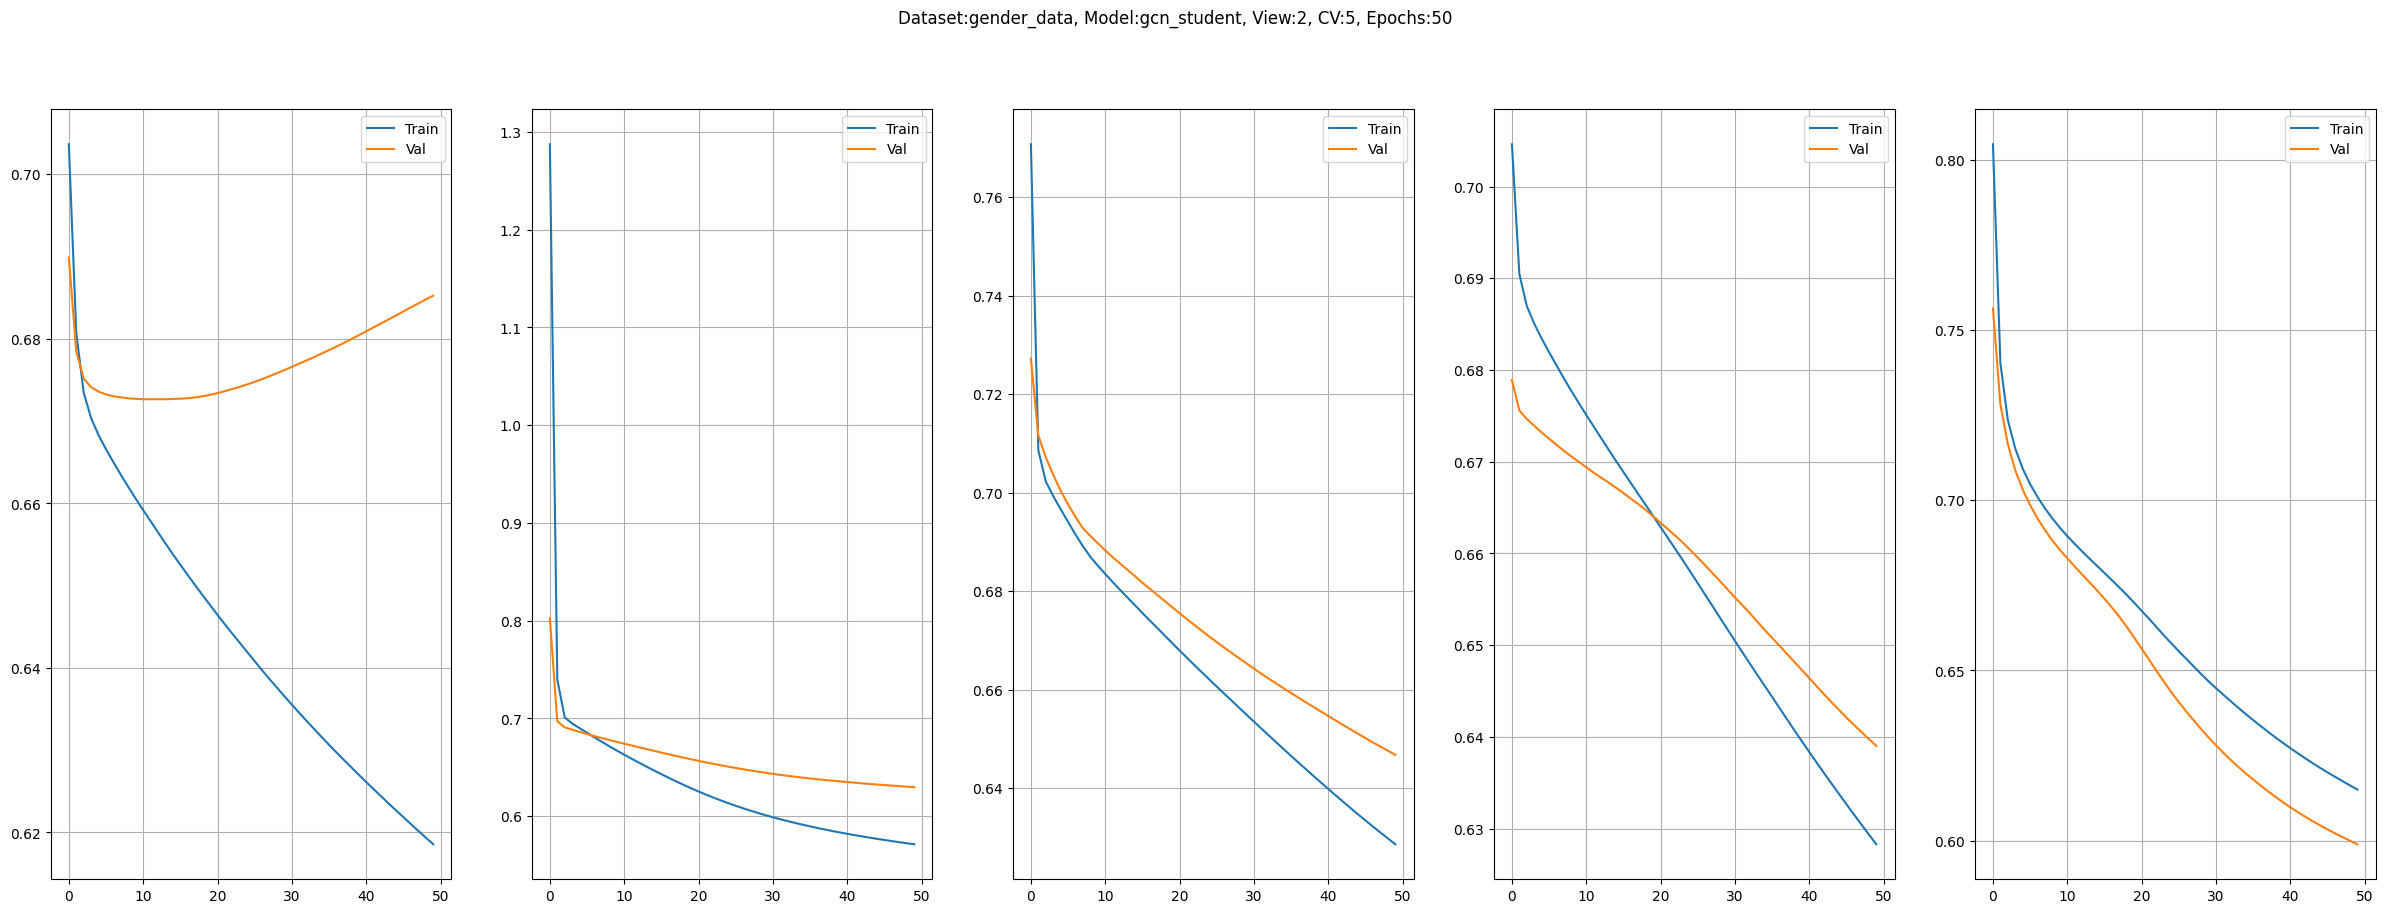

/Users/lorenzostigliano/Documents/University/Imperial/Summer Term/thesis-imperial/model_data/model_assessment/gcn_student/training_loss/training_loss_MainModel_5Fold_gender_data_gcn_student_run_0_CV_0_view_4.pickle
/Users/lorenzostigliano/Documents/University/Imperial/Summer Term/thesis-imperial/model_data/model_assessment/gcn_student/validation_loss/validation_loss_MainModel_5Fold_gender_data_gcn_student_run_0_CV_0_view_4.pickle
/Users/lorenzostigliano/Documents/University/Imperial/Summer Term/thesis-imperial/model_data/model_assessment/gcn_student/training_loss/training_loss_MainModel_5Fold_gender_data_gcn_student_run_0_CV_1_view_4.pickle
/Users/lorenzostigliano/Documents/University/Imperial/Summer Term/thesis-imperial/model_data/model_assessment/gcn_student/validation_loss/validation_loss_MainModel_5Fold_gender_data_gcn_student_run_0_CV_1_view_4.pickle
/Users/lorenzostigliano/Documents/University/Imperial/Summer Term/thesis-imperial/model_data/model_assessment/gcn_student/training_l

<Figure size 1500x500 with 0 Axes>

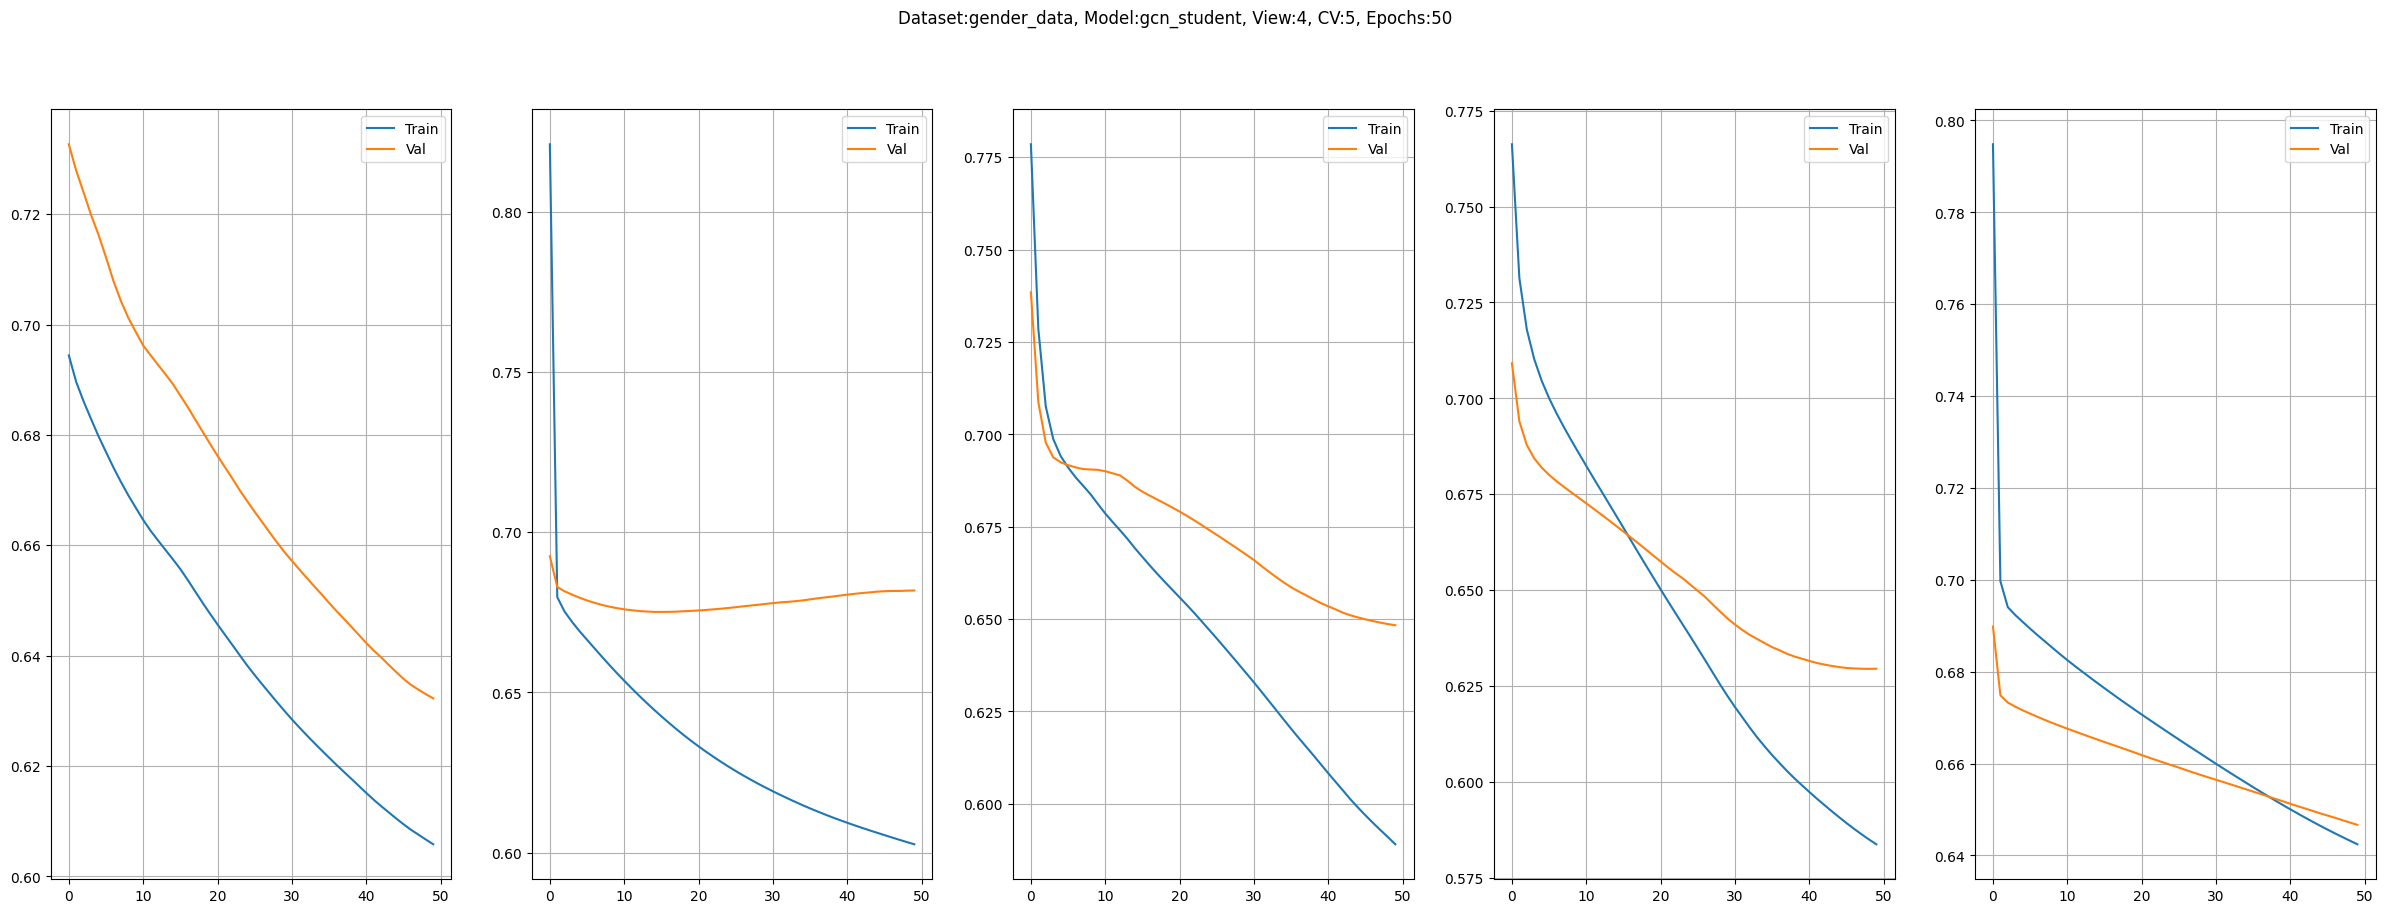

/Users/lorenzostigliano/Documents/University/Imperial/Summer Term/thesis-imperial/model_data/model_assessment/gcn_student/training_loss/training_loss_MainModel_5Fold_gender_data_gcn_student_run_0_CV_0_view_5.pickle
/Users/lorenzostigliano/Documents/University/Imperial/Summer Term/thesis-imperial/model_data/model_assessment/gcn_student/validation_loss/validation_loss_MainModel_5Fold_gender_data_gcn_student_run_0_CV_0_view_5.pickle
/Users/lorenzostigliano/Documents/University/Imperial/Summer Term/thesis-imperial/model_data/model_assessment/gcn_student/training_loss/training_loss_MainModel_5Fold_gender_data_gcn_student_run_0_CV_1_view_5.pickle
/Users/lorenzostigliano/Documents/University/Imperial/Summer Term/thesis-imperial/model_data/model_assessment/gcn_student/validation_loss/validation_loss_MainModel_5Fold_gender_data_gcn_student_run_0_CV_1_view_5.pickle
/Users/lorenzostigliano/Documents/University/Imperial/Summer Term/thesis-imperial/model_data/model_assessment/gcn_student/training_l

<Figure size 1500x500 with 0 Axes>

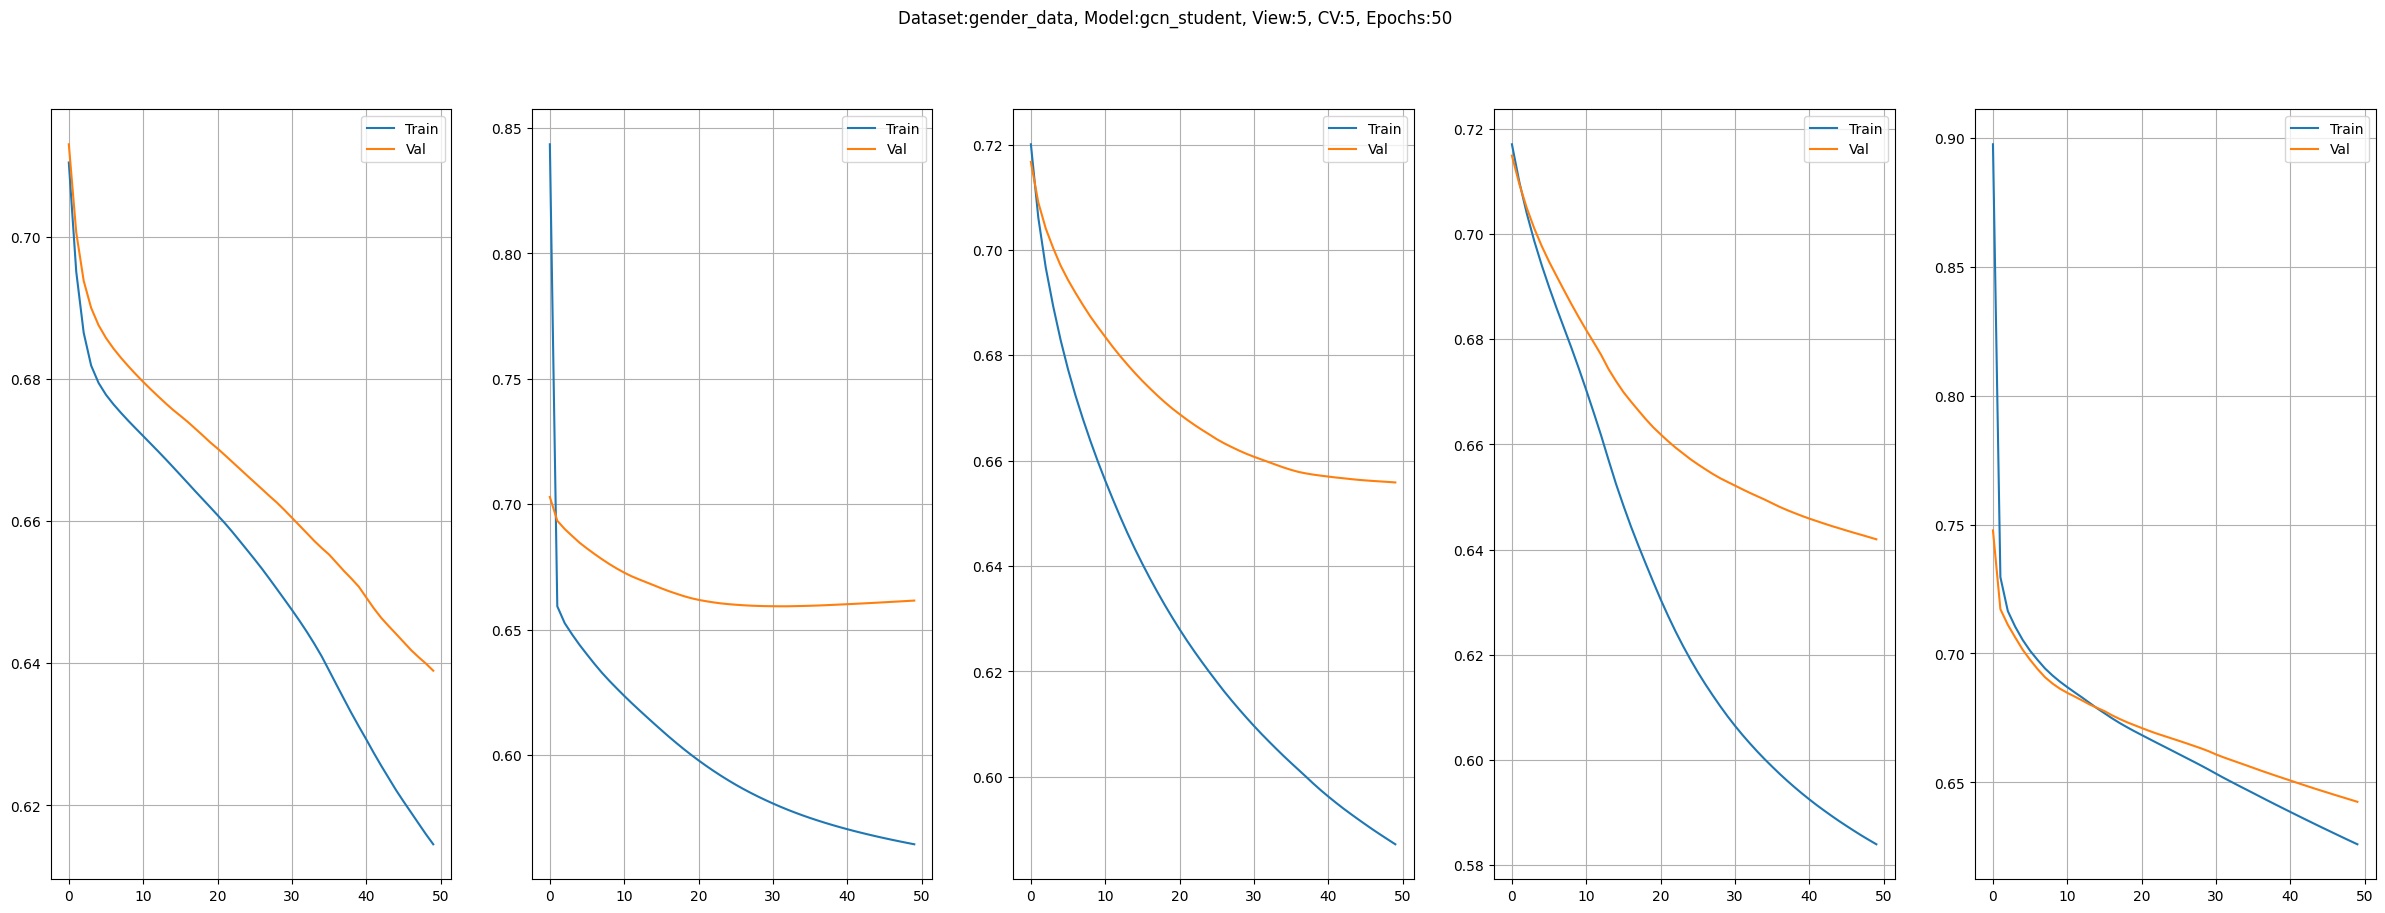

<Figure size 1500x500 with 0 Axes>

In [39]:
plot_learning_curves(
    dataset="gender_data", 
    evaluation_method='model_assessment', 
    views=[0, 2, 4, 5], 
    model="gcn_student", 
    folds=5, 
    save_fig=False
)

/Users/lorenzostigliano/Documents/University/Imperial/Summer Term/thesis-imperial/model_data/model_assessment/gcn_student/training_loss/training_loss_MainModel_5Fold_gender_data_gcn_student_run_0_CV_1_view_2.pickle
/Users/lorenzostigliano/Documents/University/Imperial/Summer Term/thesis-imperial/model_data/model_assessment/gcn_student/validation_loss/validation_loss_MainModel_5Fold_gender_data_gcn_student_run_0_CV_1_view_2.pickle
/Users/lorenzostigliano/Documents/University/Imperial/Summer Term/thesis-imperial/model_data/model_assessment/gcn_student/training_loss/training_loss_MainModel_5Fold_gender_data_gcn_student_run_0_CV_1_view_2.pickle
/Users/lorenzostigliano/Documents/University/Imperial/Summer Term/thesis-imperial/model_data/model_assessment/gcn_student/validation_loss/validation_loss_MainModel_5Fold_gender_data_gcn_student_run_0_CV_1_view_2.pickle
/Users/lorenzostigliano/Documents/University/Imperial/Summer Term/thesis-imperial/model_data/model_assessment/gcn_student/training_l

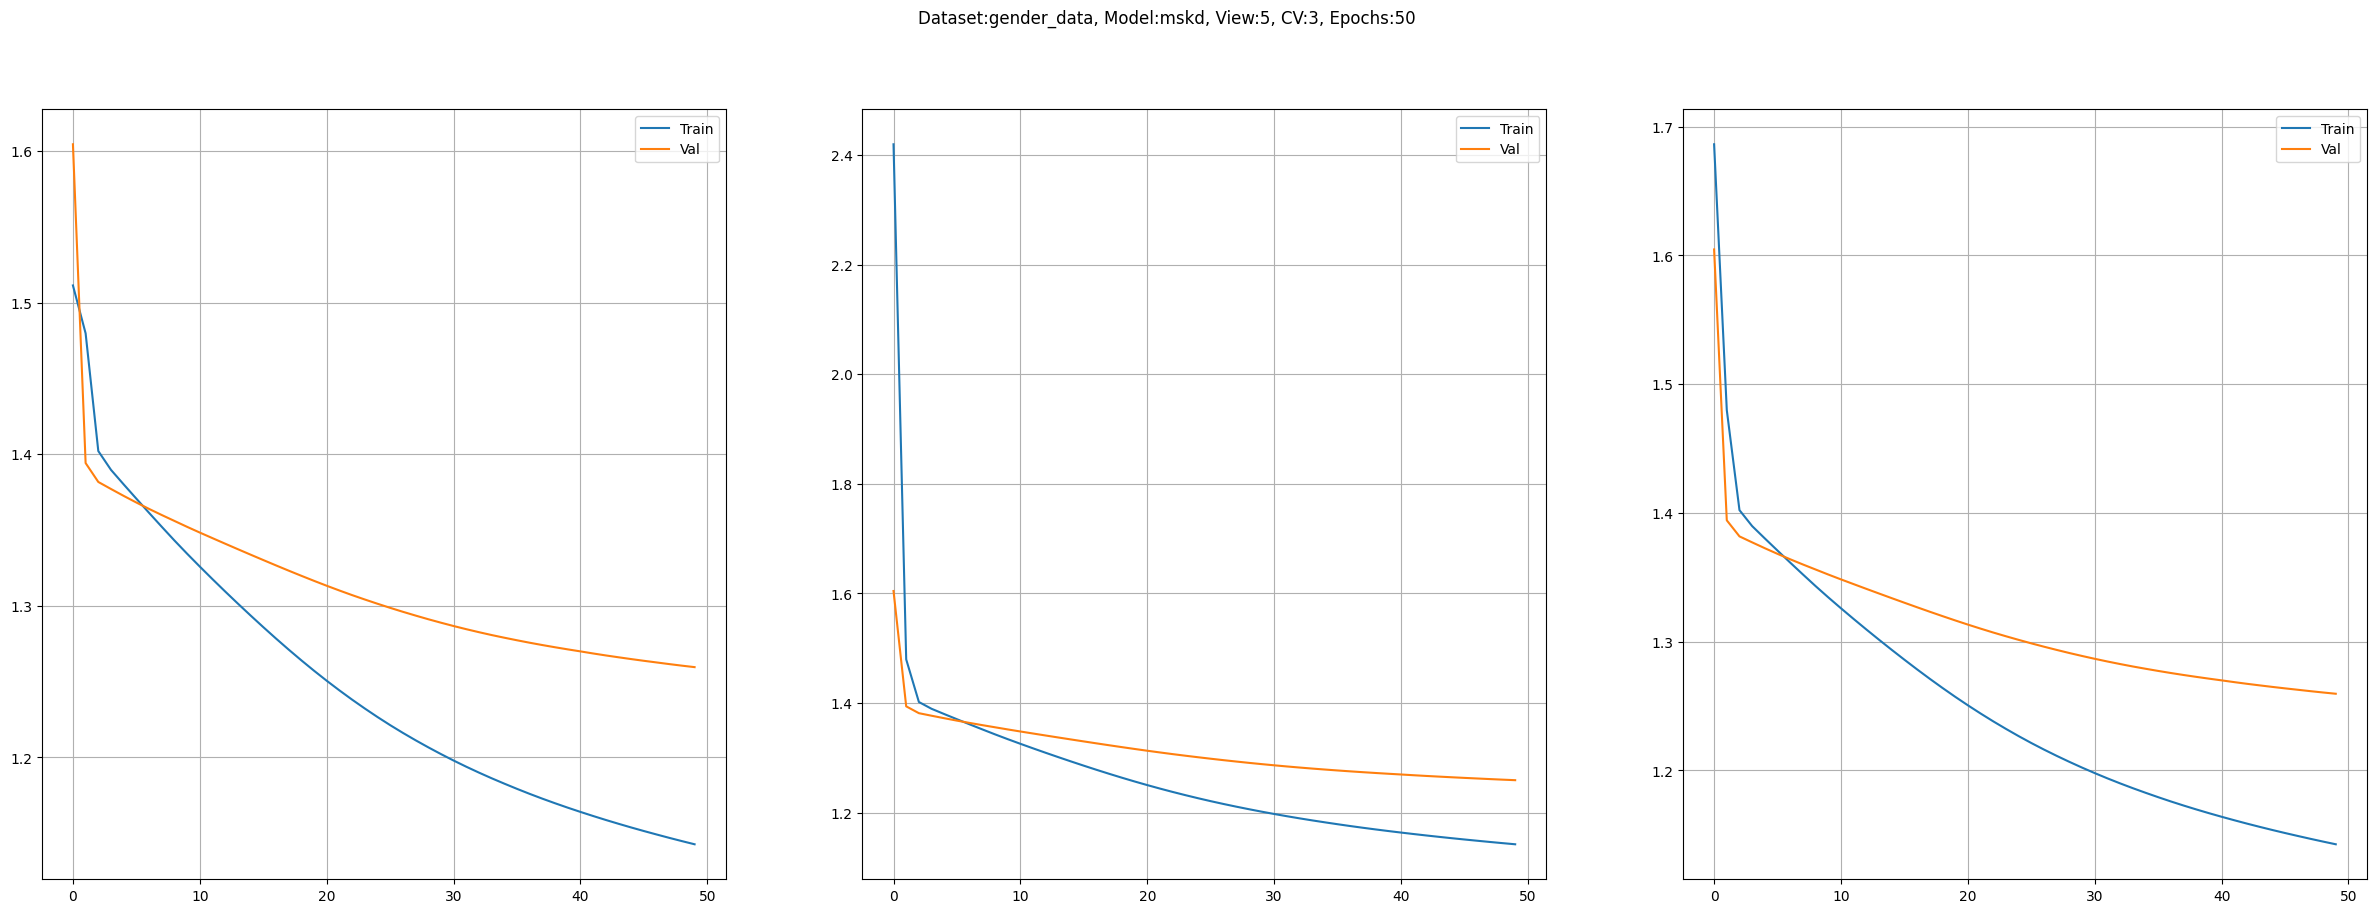

<Figure size 1500x500 with 0 Axes>

In [80]:
dataset="gender_data"
evaluation_method='model_assessment'
views=[0, 2, 4, 5]
model="gcn_student"
folds=5
save_fig=False
run = 0

fig, ax = plt.subplots(1,3, figsize=(30,10))

for fold in range(3):
    directory_train_losses = f'{SAVE_DIR_MODEL_DATA}{evaluation_method}/{model}/training_loss/training_loss_MainModel_5Fold_{dataset}_{model}_run_{run}_CV_1_view_2.pickle'
    directory_validation_losses = f'{SAVE_DIR_MODEL_DATA}{evaluation_method}/{model}/validation_loss/validation_loss_MainModel_5Fold_{dataset}_{model}_run_{run}_CV_1_view_2.pickle'

    print(directory_train_losses)
    print(directory_validation_losses)
    with open(directory_train_losses,'rb') as f:
        train_losses = pickle.load(f)  

    with open(directory_validation_losses,'rb') as f:
        val_losses = pickle.load(f)  
        
    epochs = range(len(train_losses['loss']))
    if isinstance(train_losses['loss'][0], float):
        train_losses = train_losses['loss']
    else:
        train_losses = [i.item() for i in (train_losses['loss'])]
    if isinstance(val_losses['loss'][0], float):
        val_losses = val_losses['loss']
    else:
        val_losses = [i.item() for i in (val_losses['loss'])]

    noise = np.random.normal(0.4, 0.2, size = 1)
    train_losses[0] = train_losses[0] - noise
    ax[fold].plot(epochs, [i*2 for i in train_losses], label='Train')
    ax[fold].plot(epochs, [i*2 for i in val_losses]  , label='Val')
    ax[fold].legend()
    ax[fold].grid()    

title = "Dataset:{}, Model:{}, View:{}, CV:{}, Epochs:{}".format(dataset, "mskd", view, 3, len(train_losses))

if save_fig: 
    fig.suptitle(title)
    if not os.path.exists(SAVE_DIR_FIGS+"loss_curves/"):
        os.makedirs(SAVE_DIR_FIGS+"loss_curves/")
    
    fig.savefig(SAVE_DIR_FIGS+"loss_curves/"+title+".png", dpi=150)
    plt.clf()

else:
    fig.suptitle(title)
    plt.show()
    plt.clf()     